In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.signal import detrend
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import resample
from scipy.signal import find_peaks
from scipy import signal
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

from scipy.signal import savgol_filter, lfilter
from scipy.signal import lfilter

from matplotlib.ticker import FormatStrFormatter
import matplotlib
from matplotlib import animation

### Helper Function

In [5]:
def compute_keypoints(vals): 
    
    x = np.arange(len(vals))
    
    # find peaks
    peak_idxs = find_peaks(vals, distance=len(vals)//6)[0]
    peaks = np.array([vals[i] for i in peak_idxs])
    
    if len(peaks) < 3:
        print('not enough peaks computed, bad signal')
        return [-1] * 4

    # find minima
    minima_idxs = find_peaks(-vals, distance=150)[0]
    minimas = np.array([vals[i] for i in minima_idxs])

    # start of tidal 
    start = (0, vals[0])
    
    # end of exhalation
    exhale_end_idx = peaks.argsort()[-1]
    exhale_end = (peak_idxs[exhale_end_idx], peaks[exhale_end_idx])

    # end of tidal
    peak_coords = [(x, y) for x, y in zip(peak_idxs, peaks) if x < exhale_end[0]]
    tidal_end = peak_coords[-1]

    # start of exhalation 
    minima_coords = [(x, y) for x, y in zip(minima_idxs, minimas) if x > tidal_end[0]]
    exhale_start = minima_coords[0]
    
    return start, tidal_end, exhale_start, exhale_end

def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)

# shift < 0 means that y starts 'shift' time steps before x # shift > 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

def animate_graph(x, y):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation

    x = np.linspace(0, 250, 250)
    fig, ax = plt.subplots()
    ax.set_xlabel('Image Frame Number / Time')
    ax.set_ylabel('3D Depth Sensor Chest Volume')
    line, = ax.plot(x, ysmoothed, color='k')

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        #line.axes.axis([0, 250, 0, 1])
        return line,

    ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, ysmoothed, line], interval=15, blit=True)

    # Change the video bitrate as you like and add some metadata.
    writer = animation.FFMpegWriter(fps=15, bitrate=1000)

    ani.save('test.mp4', writer=writer, dpi=900)
    plt.show()

### Load Information

In [6]:
dist_data_dir = 'D:/realsense_demos/dual_depth_demo_2/'
run_name_front = 'run_5_dist_front_updated.npy'

## loading distance variations
chest_vols_front = np.load('D:/realsense_demos/dual_depth_demo_2/run_8_dist_front.npy')
chest_vols_back = np.load('D:/realsense_demos/dual_depth_demo_2/run_8_dist_back.npy')
chest_vols = chest_vols_front - chest_vols_back
#chest_denoised = np.array([chest_vols[i] for i in range(1, len(chest_vols)) if abs(chest_vols[i] - chest_vols[i-1]) < .01])
ysmoothed = chest_vols

# ysmoothed_first = savgol_filter(ysmoothed[:400], 51, 3) # window size 51, polynomial order 3
# ysmoothed_second = savgol_filter(ysmoothed[400:], 101, 3)

# y_smooth_inh = list(ysmoothed_first)
# y_smooth_inh.extend(list(ysmoothed_second))
# ysmoothed = np.array(y_smooth_inh.copy())

## loading chest volume variations
#chest_vols = np.load('../volumes/chest_vol_3.npy')[:520]
#ysmoothed = detrend(chest_vols)
#ysmoothed = -ysmoothed

# b, a = signal.butter(1, .3, analog=False)
# ysmoothed = signal.filtfilt(b, a, ysmoothed)

#adaptive smoothing 
#different params for different parts of graph 

first_half_scale = 0.1
second_half_scale = .1

# smoothing first half 
y_smooth_inh = ysmoothed[:344]
b, a = signal.butter(1, first_half_scale, analog=False)
y_smooth_inh = signal.filtfilt(b, a, y_smooth_inh)

# smooth second half 
y_smooth_inh_after = ysmoothed[344:]
b, a = signal.butter(1, second_half_scale, analog=False)
y_smooth_inh_after = signal.filtfilt(b, a, y_smooth_inh_after)

# append together 
y_smooth_inh = list(y_smooth_inh)
y_smooth_inh.extend(list(y_smooth_inh_after))
ysmoothed = np.array(y_smooth_inh.copy())

ysmoothed = savgol_filter(ysmoothed, 31, 3) # window size 51, polynomial order 3

# # compute gradient
ysmoothed_gradient = np.gradient(ysmoothed)

## load raw spiro data
raw_flow_path = 'D:/realsense_demos/all_effort_data.xlsx'
efforts_df = pd.read_excel(raw_flow_path)
#efforts_df.dropna(inplace=True)

efforts_df.dropna(axis=1, how='all', inplace=True)
efforts_df.dropna(axis=0, how='all', inplace=True)

# # get specific effort 
sp_y_all = np.array([x for x in efforts_df[efforts_df.columns[-2]] if str(x) != 'nan'])
sp_y_flow_all = np.array([x for x in efforts_df[efforts_df.columns[-1]] if str(x) != 'nan'])

#resample_len = min(len(ysmoothed), len(sp_y_all))

sp_y = resample(sp_y_all, len(ysmoothed))
sp_y_flow = resample(sp_y_flow_all, len(ysmoothed))

In [57]:
efforts_df.columns

Index(['Volume-time(L)', 'Flow-time (L/Sec.)', 'Volume-time(L).1',
       'Flow-time (L/Sec.).1', 'Volume-time(L).2', 'Flow-time (L/Sec.).2',
       'Volume-time(L).3', 'Flow-time (L/Sec.).3', 'Volume-time(L).4',
       'Flow-time (L/Sec.).4', 'Volume-time(L).5', 'Flow-time (L/Sec.).5',
       'Volume-time(L).6', 'Flow-time (L/Sec.).6', 'Volume-time(L).7',
       'Flow-time (L/Sec.).7'],
      dtype='object')

In [58]:
efforts_df.head()

,Volume-time(L),Flow-time (L/Sec.),Volume-time(L).1,Flow-time (L/Sec.).1,Volume-time(L).2,Flow-time (L/Sec.).2,Volume-time(L).3,Flow-time (L/Sec.).3,Volume-time(L).4,Flow-time (L/Sec.).4,Volume-time(L).5,Flow-time (L/Sec.).5,Volume-time(L).6,Flow-time (L/Sec.).6,Volume-time(L).7,Flow-time (L/Sec.).7
0,3.999964,0.0,4.000043,0.0,4.000006,0.0,3.999969,0.0,4.000176,0.0,4.000004,0.0,3.999988,0.0,4.000032,0.0
1,3.999918,0.0,4.000103,0.0,4.000004,0.0,3.999933,0.0,4.000312,0.0,3.999991,0.0,3.999981,0.0,4.000065,0.0
2,3.999876,0.0,4.000181,0.0,3.999999,0.0,3.999887,0.0,4.000463,0.0,3.999971,0.0,3.999978,0.0,4.000101,0.0
3,3.999838,0.0,4.000253,0.0,3.999995,0.0,3.999827,0.0,4.000590,0.0,3.999953,0.0,3.999969,0.0,4.000144,0.0
4,3.999795,0.0,4.000328,0.0,3.999995,0.0,3.999759,0.0,4.000664,0.0,3.999940,0.0,3.999966,0.0,4.000181,0.0


### Display For Sanity Check

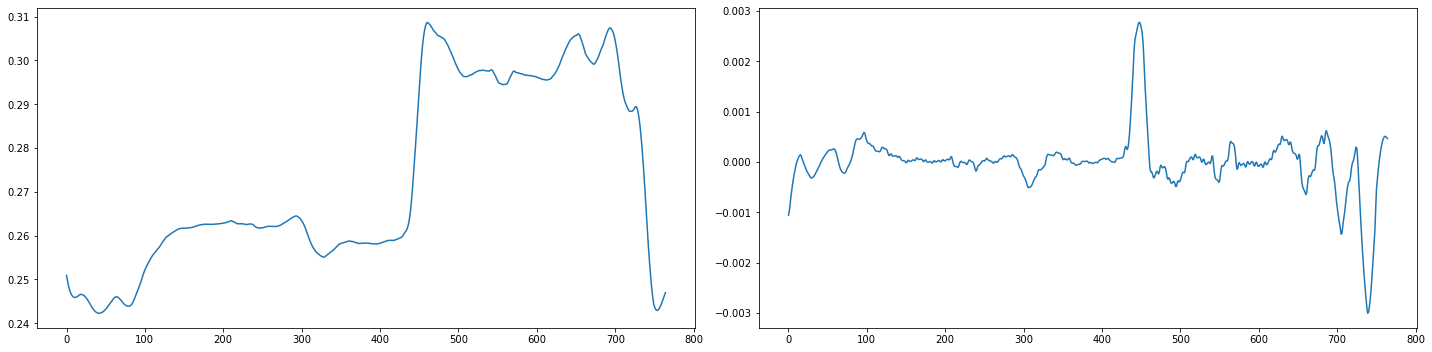

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(ysmoothed)
axes[1].plot(ysmoothed_gradient)
fig.tight_layout()

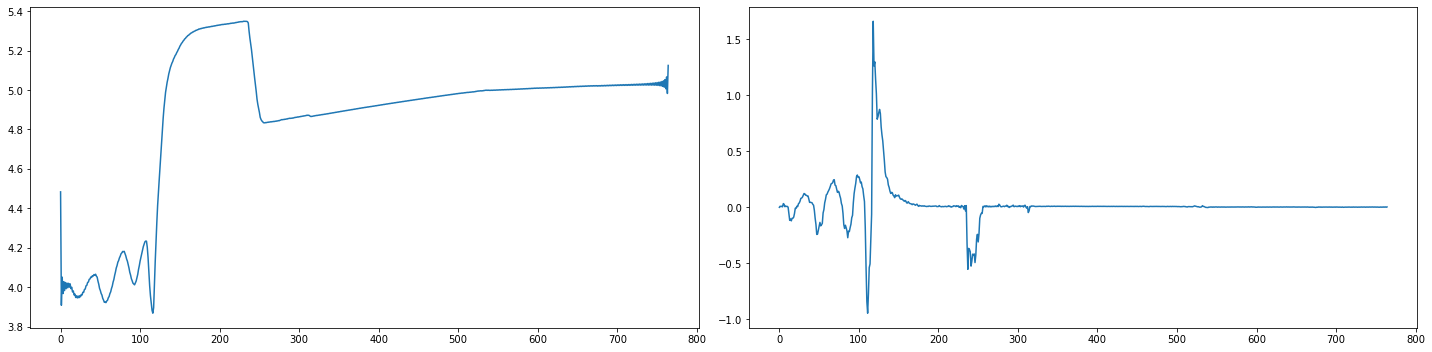

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(sp_y)
axes[1].plot(sp_y_flow)
fig.tight_layout()

### Compute Key Points

<Figure size 432x288 with 0 Axes>

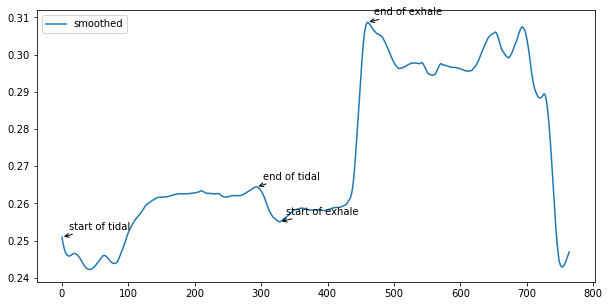

<Figure size 432x288 with 0 Axes>

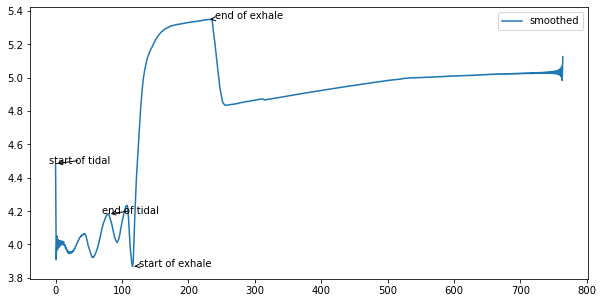

In [45]:
# compute keypoint
depth_sensor_start, depth_sensor_tidal_end, depth_sensor_exhale_start, depth_sensor_exhale_end = compute_keypoints(ysmoothed[:600])
spiro_start, spiro_tidal_end, spiro_exhale_start, spiro_exhale_end = compute_keypoints(sp_y)

if depth_sensor_start != -1: 

    plt.figure(1)
    plt.figure(figsize=(10,5))
    plt.plot(ysmoothed, '-')
    plt.legend(['smoothed'], loc='best')

    # annotate effort points
    plt.annotate('start of tidal', depth_sensor_start, 
                xytext=(depth_sensor_start[0] + 10, depth_sensor_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    plt.annotate('end of tidal', depth_sensor_tidal_end,
                xytext=(depth_sensor_tidal_end[0] + 10, depth_sensor_tidal_end[1] + .002), arrowprops=dict(arrowstyle="->"))
    plt.annotate('start of exhale', depth_sensor_exhale_start,
                xytext=(depth_sensor_exhale_start[0] + 10, depth_sensor_exhale_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    plt.annotate('end of exhale', depth_sensor_exhale_end,
                xytext=(depth_sensor_exhale_end[0] + 10, depth_sensor_exhale_end[1] + .002), arrowprops=dict(arrowstyle="->"))

    plt.show()

if spiro_start != -1:

    plt.figure(2)
    plt.figure(figsize=(10,5))
    plt.plot(sp_y, '-')
    plt.legend(['smoothed'], loc='best')

    # annotate effort points
    plt.annotate('start of tidal', spiro_start, 
                xytext=(spiro_start[0] - 10, spiro_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    plt.annotate('end of tidal', spiro_tidal_end,
                xytext=(spiro_tidal_end[0] - 10, spiro_tidal_end[1] + .002), arrowprops=dict(arrowstyle="->"))
    plt.annotate('start of exhale', spiro_exhale_start,
                xytext=(spiro_exhale_start[0] + 10, spiro_exhale_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    plt.annotate('end of exhale', spiro_exhale_end,
                xytext=(spiro_exhale_end[0] + 10, spiro_exhale_end[1] + .002), arrowprops=dict(arrowstyle="->"))

    plt.show()

### Animate Raw Volume / Spirometer Graphs

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = np.linspace(0, 10, 750)
fig, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('3D Depth Sensor Chest Volume')
line, = ax.plot(x, ysmoothed, color='k')


# annotate effort points
plt.annotate('start of tidal', intel_start, 
            xytext=(intel_start[0] + 10, intel_start[1] + .002), arrowprops=dict(arrowstyle="->"))
plt.annotate('end of tidal', intel_tidal_end,
            xytext=(intel_tidal_end[0] + 10, intel_tidal_end[1] + .002), arrowprops=dict(arrowstyle="->"))
plt.annotate('start of inhale', intel_inhalation_start,
            xytext=(intel_inhalation_start[0] + 10, intel_inhalation_start[1] + .002), arrowprops=dict(arrowstyle="->"))
plt.annotate('end of inhale', intel_inhalation_end,
            xytext=(intel_inhalation_end[0] + 10, intel_inhalation_end[1] + .002), arrowprops=dict(arrowstyle="->"))

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    if (x, y) == intel_start: 
        ax.annotate('start of tidal', intel_start, 
            xytext=(intel_start[0] + 10, intel_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    if (x, y) == intel_tidal_end: 
        ax.annotate('start of tidal', intel_start, 
            xytext=(intel_start[0] + 10, intel_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    if (x, y) == intel_inhalation_start: 
        ax.annotate('start of tidal', intel_start, 
            xytext=(intel_start[0] + 10, intel_start[1] + .002), arrowprops=dict(arrowstyle="->"))
    else: 
        
    return line

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, ysmoothed, line], interval=15, blit=True)

# Change the video bitrate as you like and add some metadata.
writer = animation.FFMpegWriter(fps=15, bitrate=1000)

ani.save('testing_new.mp4', writer=writer, dpi=900)
plt.show()

print('done')

IndentationError: expected an indented block (<ipython-input-46-240efdfce134>, line 35)

### Scale Based on Detected Key Points (Tidal & Exhalation)

In [1071]:
# get tidal breathing portion 
spiro_tidal = sp_y[spiro_start[0]:spiro_tidal_end[0]]
depth_sensor_tidal = ysmoothed[depth_sensor_start[0]:depth_sensor_tidal_end[0]]

# compute offsets and scaling factors
offset_tidal = spiro_tidal.mean()
scaling_factor_tidal = spiro_tidal.std()

# normalize depth sensor tidal signal & scale
depth_sensor_tidal_norm = (depth_sensor_tidal - depth_sensor_tidal.mean()) / depth_sensor_tidal.std()
depth_sensor_tidal_scaled = (depth_sensor_tidal_norm * scaling_factor_tidal) + offset_tidal

# get exhale portion 
spiro_exhale = sp_y[spiro_tidal_end[0]:spiro_exhale_end[0]]
depth_sensor_exhale = ysmoothed[depth_sensor_exhale_start[0]:depth_sensor_exhale_end[0]]

# compute offsets and scaling factors
offset_exhale = spiro_exhale.mean()
scaling_factor_exhale = spiro_exhale.std()

# normalize depth sensor signal exhale & scale
depth_sensor_exhale_norm = (depth_sensor_exhale - depth_sensor_exhale.mean()) / depth_sensor_exhale.std()
depth_sensor_exhale_scaled = (depth_sensor_exhale_norm * scaling_factor_exhale) + offset_exhale

### Display Scaled Signals

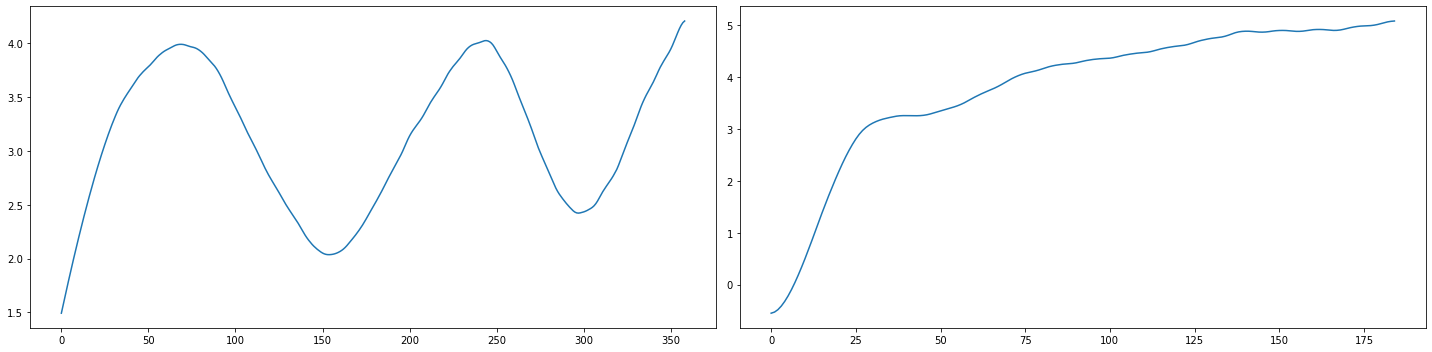

In [1072]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(depth_sensor_tidal_scaled)
axes[1].plot(depth_sensor_exhale_scaled)
fig.tight_layout()

### Scale All Together

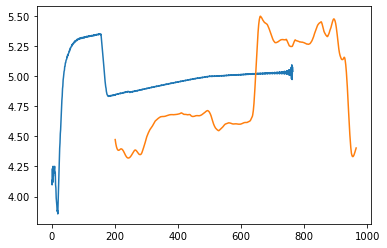

In [47]:
%matplotlib inline 

# compute offsets and scaling factors
offset_full = sp_y.mean()
scaling_factor_full = sp_y.std()

# normalize depth sensor tidal signal & scale
depth_sensor_full_norm = (ysmoothed - ysmoothed.mean()) / ysmoothed.std()
depth_sensor_full_scaled = (depth_sensor_full_norm * scaling_factor_full) + offset_full

spy_adusted = resample(sp_y[100:], len(depth_sensor_full_scaled))

# compute shift
shift_full = compute_shift(depth_sensor_full_scaled, spy_adusted)

# plot 
plt.plot(spy_adusted)
plt.plot(np.arange(765) + shift_full, depth_sensor_full_scaled)
plt.show()

### Display Scaled Flow and Volume Curves (Lung Function Graphs)

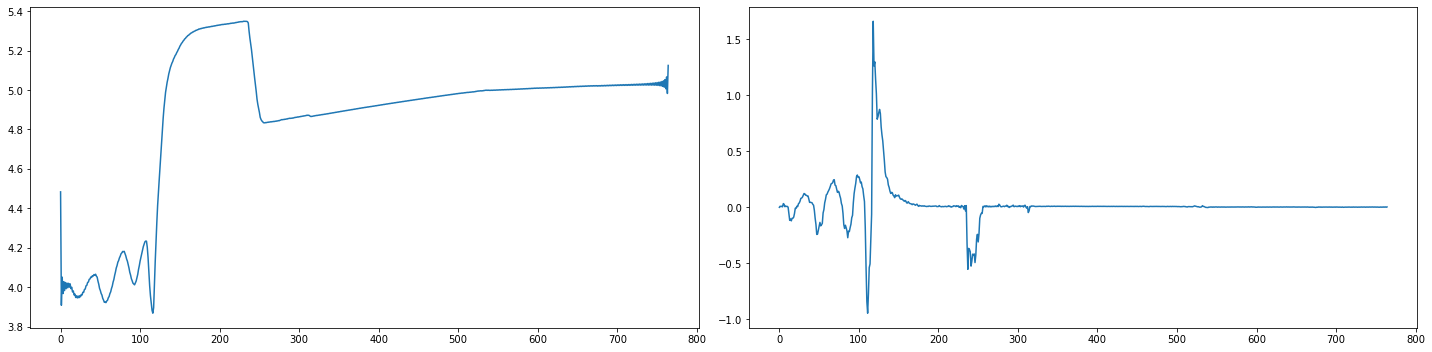

In [12]:
## display ground truth
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(sp_y)
axes[1].plot(sp_y_flow)
fig.tight_layout()

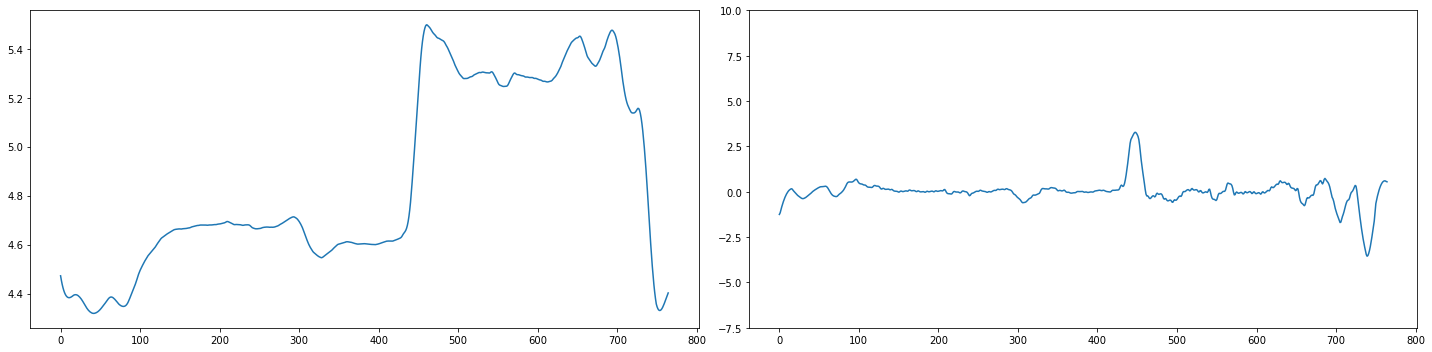

In [50]:
## display predicted from depth sensor
depth_sensor_flow = np.gradient(depth_sensor_full_scaled, .015)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].plot(depth_sensor_full_scaled)
axes[1].plot(depth_sensor_flow)
axes[1].set_yticks([-7.5, -5.0, -2.5, 0, 2.5, 5.0, 7.5, 10.0])
fig.tight_layout()

### Display Flow Volume Graphs (In Report Form)

NameError: name 'ymax' is not defined

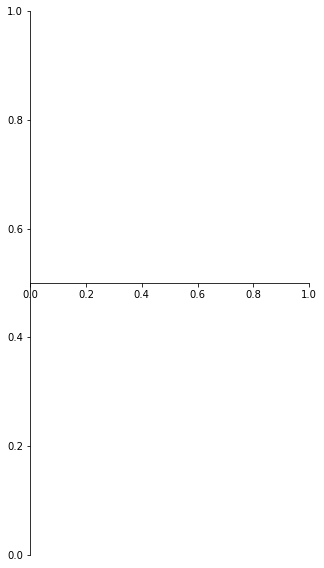

In [14]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(1, 1, 1)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')

# set x limits
y_max=12
#ymax = int(np.max(np.abs(sp_y_flow), np.abs(depth_sensor_flow)) + 1)
ax.set_ylim(-ymax, ymax)
ax.set_xlim(1, 7)

plt.plot(sp_y, sp_y_flow)

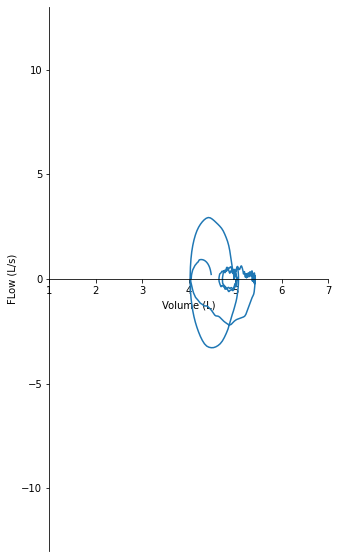

In [15]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(1, 1, 1)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')

ax.set_xlabel('Volume (L)')
ax.set_ylabel('FLow (L/s)')

# set x limits (compare to ground truth spirometer)
ymax=13
#ymax = int(np.max(np.abs(sp_y_flow)) + 1)
ax.set_ylim(-ymax, ymax)

ax.set_xlim(1, 7)

plt.plot(depth_sensor_full_scaled[40:], depth_sensor_flow[40:])

### Animate Volume Curves 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

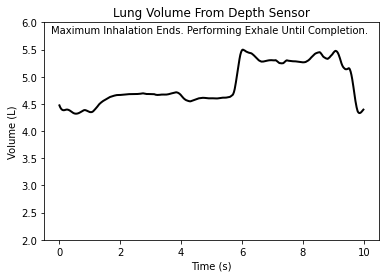

In [52]:
# First set up the figure, the axis, and the plot element we want to animate
%matplotlib inline 

fig = plt.figure()
ax = plt.axes()

ax.set_xlabel('Time (s)')
ax.set_ylabel('Volume (L)')
ax.set_title('Lung Volume From Depth Sensor')

ax.set_ylim(2, 6)

length = 765
x_vals = np.linspace(0, 10, length)
line, = ax.plot(x_vals, depth_sensor_full_scaled, color='k', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line,

# animation function.  This is called sequentially
def animate(num, x, y, line):
    print(num)
    x_val, y_val = x[num], y[num]
    if num == depth_sensor_start[0]:
        time_text.set_text('Tidal Breathing')
    elif num == depth_sensor_tidal_end[0]:
        time_text.set_text('Tidal Breathing Completed. Performing Maximum Inhalation.')
    elif num == depth_sensor_exhale_start[0]:
        time_text.set_text('Maximum Inhalation Ends. Performing Exhale Until Completion.')
    line.set_data(x[:num], y[:num])
    return line, time_text

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, fargs=[x_vals, depth_sensor_full_scaled, line], init_func=init,
                               frames=length, interval=20, blit=True)
writer = animation.FFMpegWriter(fps=15, bitrate=1000)
anim.save("shallow_breath_sensor_volume_graph.mp4", writer=writer, dpi=900)
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

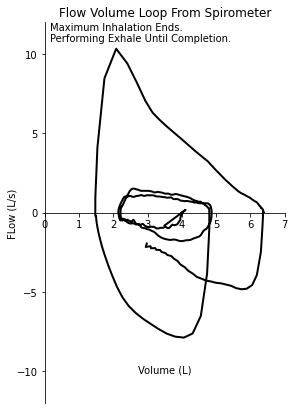

In [58]:
# First set up the figure, the axis, and the plot element we want to animate

fig = plt.figure(figsize=(4.3, 7))
ax = plt.axes()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')

ax.set_xlabel('Volume (L)')
ax.xaxis.set_label_coords(.5, 0.1)
ax.set_ylabel('FLow (L/s)', labelpad=-.5)
ax.set_title('Flow Volume Loop From Spirometer')
ax.set_ylim(-12, 12)
ax.set_xlim(0, 7)

length = 650
line, = ax.plot(sp_y, sp_y_flow, color='k', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line,

# animation function.  This is called sequentially
def animate(num, x, y, line):
    print(num)
    x_val, y_val = x[num], y[num]
    if num == spiro_start[0]:
        time_text.set_text('Tidal Breathing')
    elif num == spiro_tidal_end[0]:
        time_text.set_text('Tidal Breathing Completed. \nPerforming Maximum Inhalation.')
    elif num == spiro_exhale_start[0]:
        time_text.set_text('Maximum Inhalation Ends. \nPerforming Exhale Until Completion.')
    line.set_data(x[:num], y[:num])
    return line, time_text

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, fargs=[sp_y, sp_y_flow, line], init_func=init,
                               frames=length, interval=20, blit=True)
writer = animation.FFMpegWriter(fps=15, bitrate=1000)
anim.save('D:/realsense_data/spirometer_flow_volume.mp4', writer=writer, dpi=900)
plt.show()

### Compute PFT Measurements

In [62]:
def compute_pft_measures(exhalation, flow_volume, flow_volume_exhalation):
    
    result = []
    
    # FVC = Volume After Blast - Volume After Inhalation
    FVC = exhalation.max() - exhalation.min()
    print('FVC: ', round(FVC, 2)) 
    
    result.append(FVC)

    # FEV1 = Volume of air exhaled after one second (during exhalation blast)
    # signal is downsampled to 30 fps, so 30 frames = 1s 
    FEV1 = exhalation[31]
    print('FEV1: ', round(FEV1, 2))
    
    result.append(FEV1)

    # FEV1 / FVC 
    fev1_fvc_ratio = FEV1 / FVC
    print('FEV1 / FVC: ', round(fev1_fvc_ratio * 100, 2))
    
    result.append(fev1_fvc_ratio)

    # PEF = Maximum Flow 
    PEF = flow_volume.max()
    print('PEF: ', PEF)
    
    result.append(PEF)

    # FEF_25 = Flow of exhaled air at 25% FVC 
    fef_25_idxs = np.where(exhalation >= FVC * .25)[0]
    FEF_25 = flow_volume_exhalation[fef_25_idxs[1]]
    print('FEF_25: ', FEF_25)
    
    result.append(FEF_25)

    # FEF_50 = Flow of exhaled air at 50% FVC 
    fef_50_idxs = np.where(exhalation >= FVC * .50)[0]
    FEF_50 = flow_volume_exhalation[fef_50_idxs[1]]
    print('FEF_50: ', FEF_50)
    
    result.append(FEF_50)

    # FEF_75 = Flow of exhaled air at 75% FVC 
    fef_75_idxs = np.where(exhalation >= FVC * .75)[0]
    FEF_75 = flow_volume_exhalation[fef_75_idxs[1]]
    print('FEF_75: ', FEF_75)
    
    result.append(FEF_75)

    # FEF_25_75 = Mean forced exp flow between .25 and .75
    # (.75*FVC - .25*FVC) - (time(.25FVC) - time(.75FVC))
    FEF_25_75 = (.75*FVC - .25*FVC) / ((abs(fef_25_idxs[0] - fef_75_idxs[0])) / 30)
    print('FEF_25_75: ', FEF_25_75)
    
    result.append(FEF_25_75)
    
    return result

In [63]:
depth_sensor_flow_exhale = depth_sensor_flow[np.argmax(depth_sensor_flow):depth_sensor_exhale_end[0]]
pft_results = compute_pft_measures(depth_sensor_exhale_scaled, depth_sensor_flow, depth_sensor_flow_exhale)

FVC:  4.52
FEV1:  4.03
FEV1 / FVC:  89.14
PEF:  9.975004646589685
FEF_25:  8.747971648201025
FEF_50:  6.506786871015358
FEF_75:  3.617883474077181
FEF_25_75:  3.7700798116094365


### Classifying: Normal, Obstructive, or Restrictive 

In [64]:
def get_normal_val(df, patient_age, patient_height):
    
    # get ref age 
    nhanes_ages = df.columns.values
    min_index = np.abs(nhanes_ages - patient_age).argmin()
    reference_age = nhanes_ages[min_index]
    
    if len(df) == 1: 
        return df.loc[0, reference_age]

    # get ref height
    nhanes_heights = df.index.values
    min_index = np.abs(nhanes_heights - patient_height).argmin()
    reference_height = nhanes_heights[min_index]
    
    return df.loc[reference_height, reference_age]

In [65]:
fev1_df = pd.read_excel('../predicted_values/fev1_cauc_male.xlsx', index_col=0)
fev1_lm_df = pd.read_excel('../predicted_values/fev1_cauc_male_lower_lim_norm.xlsx', index_col=0)

fvc_df = pd.read_excel('../predicted_values/fvc_cauc_male.xlsx', index_col=0)
fvc_lm_df = pd.read_excel('../predicted_values/fvc_cauc_male_lower_lim_norm.xlsx', index_col=0)

fev1_fvc_ratio_df = pd.read_excel('../predicted_values/fev1_fvc_ratio_cauc_male.xlsx')
fev1_fvc_ratio_lm_df = pd.read_excel('../predicted_values/fev1_fvc_cauc_male_ratio_lower_lim_norm.xlsx')
fev1_fvc_ratio_lm_df = fev1_fvc_ratio_lm_df[fev1_fvc_ratio_lm_df.columns[:-2]]
fev1_fvc_ratio_lm_df = fev1_fvc_ratio_lm_df[:-2]

pef_df = pd.read_excel('../predicted_values/pef_cauc_male.xlsx', index_col=0)
pef_lm_df = pd.read_excel('../predicted_values/pef_cauc_male_lower_lim_norm.xlsx', index_col=0)

In [66]:
# put in Xavier's profile 
patient_age = 24 
patient_race = 'Asian / Caucasion'
patient_height = 175.5

In [67]:
# get fev1 normal
fev1_normal = get_normal_val(fev1_df, patient_age, patient_height)

# get fvc normal
fvc_normal = get_normal_val(fvc_df, patient_age, patient_height)

# get fev1_fvc_ratio normal
fev1_fvc_ratio_normal = get_normal_val(fev1_fvc_ratio_df, patient_age, patient_height)

# get pef normal
pef_normal = get_normal_val(pef_df, patient_age, patient_height)

In [68]:
# get fev1 normal
fev1_lower_normal = get_normal_val(fev1_lm_df, patient_age, patient_height)

# get fvc normal
fvc_lower_normal = get_normal_val(fvc_lm_df, patient_age, patient_height)

# get fev1_fvc_ratio normal
fev1_fvc_ratio_lower_normal = get_normal_val(fev1_fvc_ratio_lm_df, patient_age, patient_height)

# get pef normal
pef_lower_normal = get_normal_val(pef_lm_df, patient_age, patient_height)

In [69]:
print(fev1_lower_normal)
print(fvc_lower_normal)
print(fev1_fvc_ratio_lower_normal)
print(pef_lower_normal)

3.68
4.48
0.73
7.71


In [70]:
pft_ranking = []
if pft_results[1] > fev1_lower_normal:
    print('FEV1 is normal: ', str(pft_results[1]) + ' | ' + str(round(pft_results[1] / fev1_normal, 2) * 100) + '%')
    pft_ranking.append(1)
else: 
    print('FEV1 is not normal: ', str(pft_results[1]) + ' | ' + str(round(pft_results[1] / fev1_normal, 2) * 100) + '%')
    pft_ranking.append(0)
    
if pft_results[0] > fvc_lower_normal:
    print('FVC is normal: ', str(pft_results[0]) + ' | ' + str(round(pft_results[0] / fvc_normal, 2) * 100) + '%')
    pft_ranking.append(1)
else: 
    print('FVC not normal: ', str(pft_results[0]) + ' | ' + str(round(pft_results[0] / fvc_normal, 2) * 100) + '%')
    pft_ranking.append(0)
    
if pft_results[2] > fev1_fvc_ratio_lower_normal:
    print('FEV1/FVC is normal: ', str(pft_results[2]) + ' | ' + str(round(pft_results[2] / fev1_fvc_ratio_normal, 2) * 100) + '%')
    pft_ranking.append(1)
else: 
    print('FEV1/FVC is not normal: ',  str(pft_results[2]) + ' | ' + str(round(pft_results[2] / fev1_fvc_ratio_normal, 2) * 100) + '%')
    pft_ranking.append(0)
    
if pft_results[3] > pef_normal:
    print('PEF is normal: ', str(pft_results[3]) + ' | ' + str(round(pft_results[3] / pef_normal, 2) * 100) + '%')
    pft_ranking.append(1)
else: 
    print('PEF is not normal: ', str(pft_results[3]) + ' | ' + str(round(pft_results[3] / pef_normal, 2) * 100) + '%')
    pft_ranking.append(0)

FEV1 is normal:  4.032899148674889 | 91.0%
FVC is normal:  4.524095773931324 | 84.0%
FEV1/FVC is normal:  0.8914265634943448 | 107.0%
PEF is normal:  9.975004646589685 | 100.0%


In [71]:
def arc_length(x, y):
    npts = len(x)
    arc = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    for k in range(1, npts):
        arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2)

    return arc

def get_angle(p0, p1, p2):
    ''' compute angle (in degrees) for p0p1p2 corner
    Inputs:
        p0,p1,p2 - points in the form of [x,y]
    '''
    
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p0) - np.array(p2)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    
    return np.degrees(angle)

In [72]:
exhalation_curve = depth_sensor_flow[depth_sensor_exhale_start[0]:depth_sensor_exhale_end[0]]
exhalation_curve_normalized = (exhalation_curve - exhalation_curve.mean()) / exhalation_curve.std()

# extract 3 points for angle computation
peak_idx = exhalation_curve_normalized.argmax()
p0 = (peak_idx, exhalation_curve_normalized[peak_idx])
p1 = (0, exhalation_curve_normalized[0])
p2 = (len(exhalation_curve_normalized), exhalation_curve_normalized[-1])

# compute angle
curve_angle = get_angle(p0, p1, p2)

# compute arc length 
curve_length = arc_length(np.arange(len(exhalation_curve_normalized)), exhalation_curve_normalized)

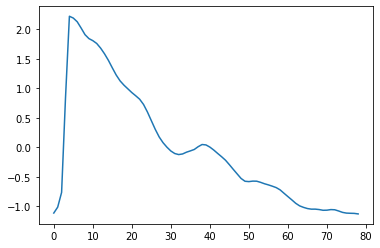

In [73]:
plt.plot(exhalation_curve_normalized)

In [74]:
curve_angle

137.62757109277584

In [75]:
curve_length

80.78426924119263

### Visualize Interpretation

In [78]:
from matplotlib.widgets import Button

In [89]:
%matplotlib widget
    
fig, ax = plt.subplots(figsize=(5, 8))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('center')
time_text = ax.text(.2, 1, 'Click "Y" to begin\n automated interpretation', fontsize=8, bbox=dict(facecolor='none', edgecolor='red', boxstyle='square, pad=1'), transform=ax.transAxes)
line, = ax.plot(depth_sensor_full_scaled[40:], depth_sensor_flow[40:], color='k', lw=2)

print('entered')

class Index(object):
    
    count = 0

    def correct_interp(self, event):
        
        if self.count == 0: 
            time_text.set_text('FVC: ' + str(round(pft_results[0], 2)) + '\n' + 
                               'FEV1: ' + str(round(pft_results[1], 2)) + '\n' + 
                               'FEV1 / FVC: ' + str(round(pft_results[2], 2)) + '\n' +
                               'PEF: ' + str(round(pft_results[3], 2)) + '\n'
                               'FEF_25_75: ' + str(round(pft_results[7], 2)) + '\n')
        if self.count == 1: 
            if pft_results[1] > fev1_lower_normal:
                time_text.set_text('FEV1 is normal: \n' + str(round(pft_results[1], 2)) + ' | ' + str(round(pft_results[1] / fev1_normal, 2) * 100) + '%')
            else: 
                time_text.set_text('FEV1 not normal: \n', str(round(pft_results[1], 2)) + ' | ' + str(round(pft_results[1] / fev1_normal, 2) * 100) + '%')
                
        if self.count == 2: 
            if pft_results[0] > fvc_lower_normal:
                 time_text.set_text('FVC is normal: \n' + str(round(pft_results[0], 2)) + ' | ' + str(round(pft_results[0] / fvc_normal, 2) * 100) + '%')
            else: 
                 time_text.set_text('FVC is not normal: \n' + str(round(pft_results[0], 2)) + ' | ' + str(round(pft_results[0] / fvc_normal, 2) * 100) + '%')
                    
        if self.count == 3: 
            if pft_results[0] > fvc_lower_normal:
                 time_text.set_text('FEV1/FVC is normal: \n' + str(round(pft_results[2], 2)) + ' | ' + str(round(pft_results[2] / fev1_fvc_ratio_normal, 2) * 100) + '%')
            else: 
                 time_text.set_text('FEV1/FVC is not normal: \n' + str(round(pft_results[2], 2)) + ' | ' + str(round(pft_results[2] / fev1_fvc_ratio_normal, 2) * 100) + '%')
        
        if self.count == 4: 
            time_text.set_text('Computed curve angle: ' + str(round(curve_angle, 2)) + '\n' + 
                               'Computed curve length: ' + str(round(curve_length, 2)) + '\n' + 
                               'Therefore has healthy, terminal curvilinearity')
            
        if self.count == 5: 
            time_text.set_position((.05, 1))
            time_text.set_text('FINAL INTERPRETATION: \n' + 
                               'PFT Measures: All Normal \n' + 
                               'Flow Volume Graph: Normal \n' +
                               'Volume Graph: Normal \n' + 
                               'There is no evidence of obstructive or restrictive defects.\n' +
                               'Patient has healthy, normal lung function.')
            
        self.count += 1
        self.fig.canvas.draw()

    def incorrect_interp(self, event):
        time_text.set_text('Interpretation has been removed from \n' + 
                           'automated report. Click "Y" to continue.')
        
        self.count += 1
        self.fig.canvas.draw()

callback = Index()
axprev = plt.axes([0.87, 0.9, .05, .03])
axnext = plt.axes([0.93, 0.9, .05, 0.03])

bnext = Button(axnext, 'Y')
bnext.on_clicked(callback.correct_interp)
print('reached')
bprev = Button(axprev, 'N')
bprev.on_clicked(callback.incorrect_interp)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

entered
reached
